# Задание

Предсказание названия покемонов по изображениям.

In [ ]:
# pip install datasets

In [ ]:
# !pip install numpy==1.26.4

In [ ]:
#!pip install ultralytics

# Импорты

In [1]:
import logging
import os
import random
import shutil
import time
import warnings
from datetime import datetime
from math import ceil
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
from IPython.display import Image, display
from PIL import Image
from PIL import Image as PILImage
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import EfficientNet_V2_S_Weights, ResNet50_Weights
from torchvision.utils import make_grid
from tqdm import tqdm
from ultralytics import YOLO

In [2]:
plt.style.use("ggplot")

In [3]:
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 20)
pd.set_option("display.precision", 4)
pd.set_option("plotting.backend", "matplotlib")

In [4]:
warnings.simplefilter("ignore")

In [5]:
train_labels_data = pd.read_csv("train_labels.csv")

In [6]:
train_labels_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4773 entries, 0 to 4772
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  4773 non-null   object
 1   label     4773 non-null   object
dtypes: object(2)
memory usage: 74.7+ KB


In [7]:
train_labels_data.head()

,filename,label
0,272950c0fe7d5ef229cc3f91b2b69f0308ae0338fdb8b7...,Koffing
1,a2941695eec38325034b78762e6a5e7e8d691fb4e0cd3a...,Venonat
2,af7224ba0effb5d83a3d4c1501167092aa812661196047...,Nidoking
3,022afb8d96bdfa5063c27d841b76fe0b00de5cb73f80d1...,Victreebel
4,82591d76b5a89abd6f7bba9ac1f0d847dd4608b859401c...,Persian


# EDA

In [7]:
def plot_category_counts(df, column_name):
    """
    Построение графика для визуализации количества объектов каждой категории заданного признака.
    Над каждой колонкой отображается количество объектов.

    Параметры:
    - df (pd.DataFrame): Датафрейм, содержащий анализируемые данные.
    - column_name (str): Название колонки (признака), для которой будет строиться график.
    """
    category_counts = df[column_name].value_counts()

    plt.figure(figsize=(30, 6))
    bars = category_counts.plot(kind="bar")
    plt.title(f"Количество изображений по типам pokemon-ов")
    plt.xlabel("Категория")
    plt.ylabel("Количество объектов")
    plt.xticks()
    plt.grid(axis="y", linestyle="--")

    plt.show()

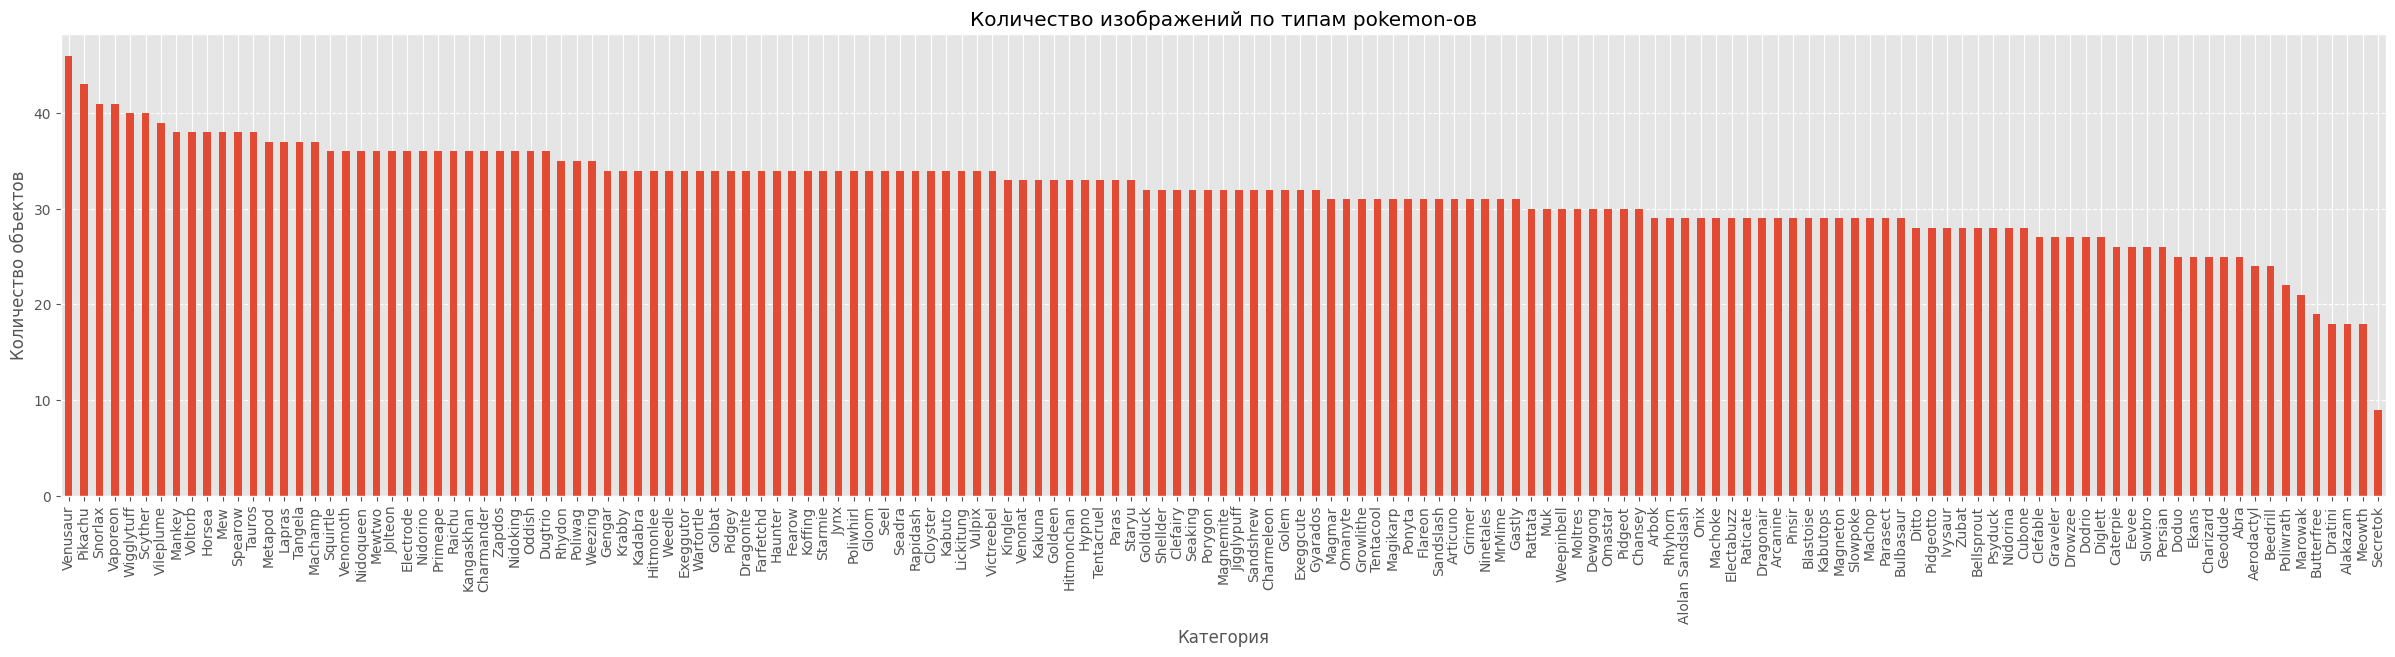

In [8]:
plot_category_counts(train_labels_data, "label")

* Наблюдается несущественный дисбаланс
* В большинстве случаев для каждого типа имеем от 20 до 40 изображений

## Названия покемонов

In [20]:
unq_pokemons_name = train_labels_data["label"].unique()

In [21]:
num_of_unq_pokemons = len(unq_pokemons_name)

In [22]:
print("Количество уникальных названий покемонов:", num_of_unq_pokemons)

Количество уникальных названий покемонов: 151


In [23]:
unq_pokemons_name

array(['Koffing', 'Venonat', 'Nidoking', 'Victreebel', 'Persian', 'Ekans', 'Jigglypuff', 'Vulpix', 'Lickitung', 'Cloyster', 'Paras', 'Pidgeotto', 'Rapidash', 'Ditto', 'Clefairy', 'Charmander', 'Kakuna', 'Flareon', 'Charmeleon', 'Raichu', 'Seel', 'Omanyte', 'Machamp', 'Tauros', 'Primeape', 'Ponyta', 'Hitmonchan',
       'Mankey', 'Electabuzz', 'Chansey', 'Hypno', 'Gloom', 'Nidoqueen', 'Vaporeon', 'Rattata', 'Metapod', 'Sandshrew', 'Kabuto', 'Eevee', 'Pinsir', 'Arbok', 'Kabutops', 'Seadra', 'Lapras', 'Arcanine', 'Poliwhirl', 'Gyarados', 'Jynx', 'Venusaur', 'Venomoth', 'Kadabra', 'Butterfree', 'Seaking', 'Tangela', 'Slowpoke',
       'Growlithe', 'Marowak', 'Spearow', 'Electrode', 'Drowzee', 'Dewgong', 'Squirtle', 'Magnemite', 'Exeggcute', 'Bulbasaur', 'Golbat', 'Weezing', 'Muk', 'MrMime', 'Porygon', 'Magmar', 'Sandslash', 'Raticate', 'Vileplume', 'Wigglytuff', 'Starmie', 'Wartortle', 'Gastly', 'Voltorb', 'Horsea', 'Alakazam', 'Psyduck',
       'Fearow', 'Parasect', 'Blastoise', 'Tentacru

In [14]:
lowercase_unq_pokemons_name = [s.lower() for s in unq_pokemons_name]

# Расширение датасета
Эти изображения из другого датасета. Изображения не содержат тестовой выборки.

In [ ]:
# Путь к папке с картинками
images_folder = "images"

# Создаем пустой датасет
new_pokemon_data = []

# Проходим по всем файлам в папке
for filename in os.listdir(images_folder):
    # Получаем имя покемона из названия файла (без расширения)
    pokemon_name = os.path.splitext(filename)[0]

    # Если покемон в списке нужных
    if pokemon_name in lowercase_unq_pokemons_name:
        # Добавляем в датасет
        new_pokemon_data.append(
            {"filename": filename, "label": pokemon_name.capitalize()}
        )

# Преобразуем список в DataFrame
new_pokemon_df = pd.DataFrame(new_pokemon_data)

In [ ]:
new_pokemon_df.info()

Получили плюс 148 изображений (одно изображение для класса).

## Размер изображений

In [13]:
def plot_image_size_distribution(image_folder):
    """
    Строит два boxplot: один для ширины изображений и один для высоты изображений.
    Изображения берутся из всех папок в указанной директории.

    :param image_folder: Путь к корневой папке, содержащей папки с изображениями.

    """

    # Списки для хранения данных о размерах изображений
    widths = []
    heights = []

    # Проход по папкам внутри корневой папки
    for label in os.listdir(image_folder):
        label_folder = os.path.join(image_folder, label)

        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                image_path = os.path.join(label_folder, filename)

                if os.path.isfile(image_path):
                    # Открываем изображение и извлекаем его размер
                    with Image.open(image_path) as img:
                        width, height = img.size
                        widths.append(width)
                        heights.append(height)

    # Создаем DataFrame для удобства работы с данными
    df = pd.DataFrame({"Width": widths, "Height": heights})

    # Построение графиков
    plt.figure(figsize=(14, 7))

    # Boxplot для ширины изображений
    plt.subplot(1, 2, 1)
    sns.boxplot(y=df["Width"])
    plt.title("Распределение ширины изображений")
    plt.ylabel("Ширина (пиксели)")
    plt.grid(True, linestyle="--", alpha=0.6)

    # Добавление квантилей для ширины
    q1, median, q3 = df["Width"].quantile([0.25, 0.5, 0.75])
    plt.text(0, q1, f"Q1: {int(q1)}", ha="center", va="top", fontsize=8, color="blue")
    plt.text(
        0,
        median,
        f"Median: {int(median)}",
        ha="center",
        va="center",
        fontsize=8,
        color="black",
    )
    plt.text(
        0, q3, f"Q3: {int(q3)}", ha="center", va="bottom", fontsize=8, color="blue"
    )

    # Boxplot для высоты изображений
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df["Height"])
    plt.title("Распределение высоты изображений")
    plt.ylabel("Высота (пиксели)")
    plt.grid(True, linestyle="--", alpha=0.6)

    # Добавление квантилей для высоты
    q1, median, q3 = df["Height"].quantile([0.25, 0.5, 0.75])
    plt.text(0, q1, f"Q1: {int(q1)}", ha="center", va="top", fontsize=8, color="blue")
    plt.text(
        0,
        median,
        f"Median: {int(median)}",
        ha="center",
        va="center",
        fontsize=8,
        color="black",
    )
    plt.text(
        0, q3, f"Q3: {int(q3)}", ha="center", va="bottom", fontsize=8, color="blue"
    )

    plt.tight_layout()
    plt.show()

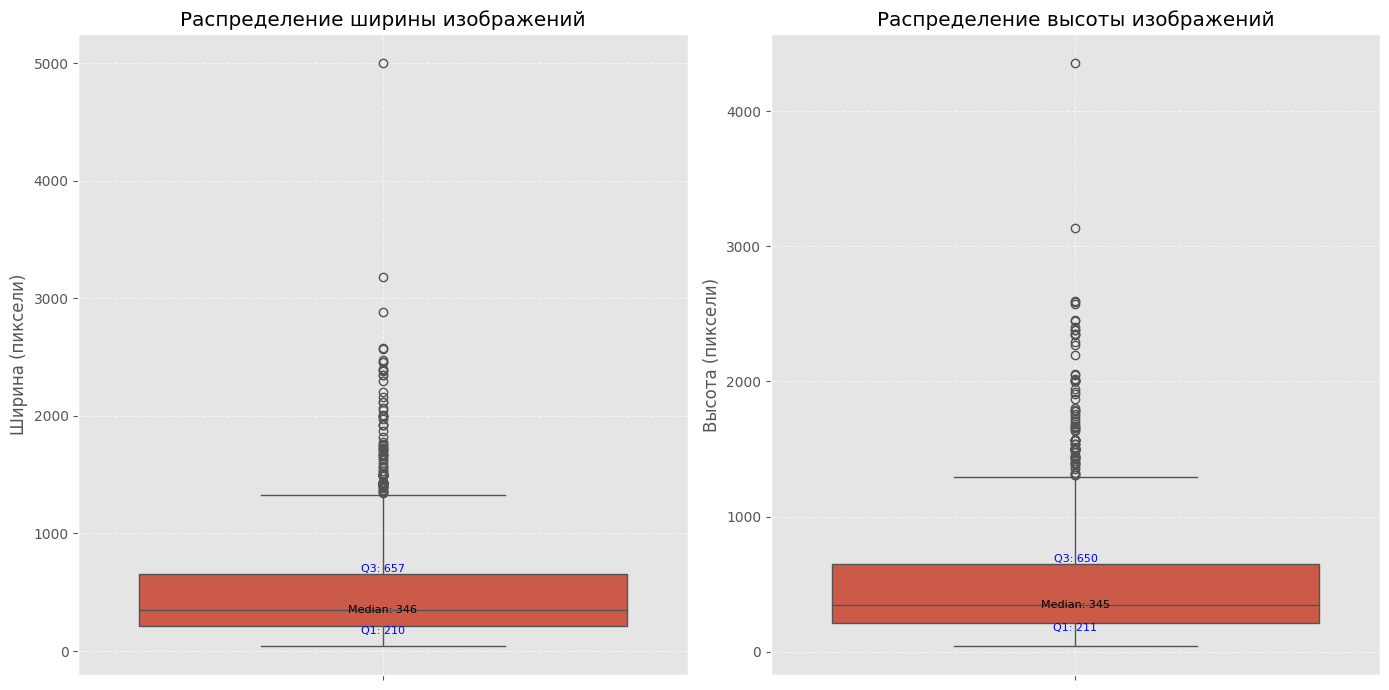

In [14]:
plot_image_size_distribution("train_foldered")

# Просмотр изображений для покемонов

In [15]:
def display_pokemon_images(folder_path, pokemon_name, df, size=(128, 128)):
    """
    Выводит все изображения покемона из указанной папки на основе переданного датасета.

    Args:
        folder_path (str): Путь к папке с изображениями.
        pokemon_name (str): Имя покемона для поиска изображений.
        df (pd.DataFrame): Датасет с колонками 'filename' и 'label'.
        size (tuple): Размер изображений (width, height). По умолчанию (128, 128).

    Returns:
        None: Функция выводит изображения и сообщения о статусе, ничего не возвращая.
    """
    # Приводим имя покемона к правильному регистру
    pokemon_name = pokemon_name.capitalize()

    # Получаем строки из датасета, соответствующие данному покемону
    filtered_df = df[df["label"] == pokemon_name]

    # Если таких строк нет, выводим сообщение
    if filtered_df.empty:
        print(f"Нет изображений для покемона: {pokemon_name}")
        return

    # Проходим по всем найденным строкам и выводим изображения
    for filename in filtered_df["filename"]:
        file_path = os.path.join(folder_path, filename)
        with PILImage.open(file_path) as img:
            # Изменяем размер изображения
            img = img.resize(size, PILImage.LANCZOS)
            display(img)

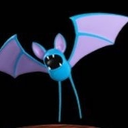

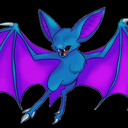

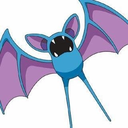

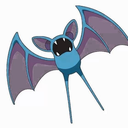

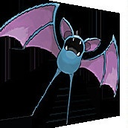

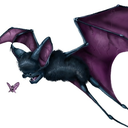

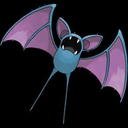

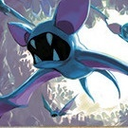

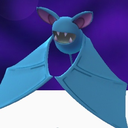

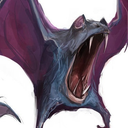

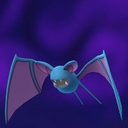

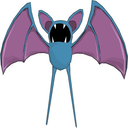

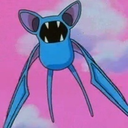

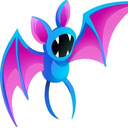

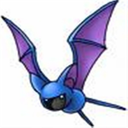

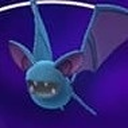

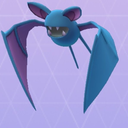

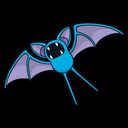

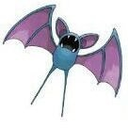

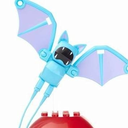

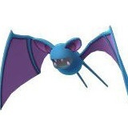

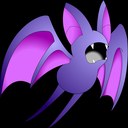

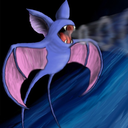

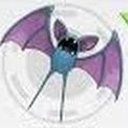

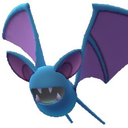

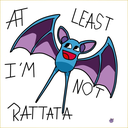

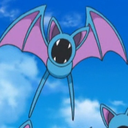

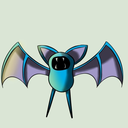

In [16]:
display_pokemon_images("train_foldered/Zubat", "Zubat", train_labels_data)

# Folder Aggregation
Приведение данных к виду для datasets.ImageFolder

In [ ]:
def distribute_images_by_category(image_folder, df, output_folder):
    """
    Распределяет изображения по папкам на основе категорий, указанных в DataFrame.

    Параметры:
    - image_folder (str): Путь к папке, содержащей оригинальные изображения.
    - df (pd.DataFrame): DataFrame с колонками 'filename' и 'label'.
    - output_folder (str): Путь к выходной папке, где изображения будут организованы по папкам категорий.

    DataFrame должен иметь следующую структуру:
    filename,label
    image1.jpg,cat1
    image2.jpg,cat2
    ...

    Функция создаст папки для каждой уникальной категории в output_folder и переместит
    соответствующие изображения в эти папки.
    """

    # Создание выходной папки, если она не существует
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Перебор строк в DataFrame
    for index, row in df.iterrows():
        filename = row["filename"]
        category = row["label"]

        # Путь к файлу изображения
        src_path = os.path.join(image_folder, filename)

        # Путь к папке категории
        category_folder = os.path.join(output_folder, category)

        # Создание папки категории, если она не существует
        if not os.path.exists(category_folder):
            os.makedirs(category_folder)

        # Путь для сохранения файла в папке категории
        dst_path = os.path.join(category_folder, filename)

        # Перемещение файла
        shutil.move(src_path, dst_path)

    print("Изображения успешно распределены по папкам.")

In [ ]:
# distribute_images_by_category(
#     "train_test_data/train", train_labels_data, "train_foldered"
# )

In [ ]:
# distribute_images_by_category("images", new_pokemon_df, "train_foldered")

In [ ]:
def organize_images(source_dir, target_dir):
    """
    Организует изображения из исходной директории в новую целевую директорию.

    Эта функция создает новую директорию с указанным именем целевой директории.
    Внутри этой директории создается другая директория с названием "no_label" и
    все файлы изображений из исходной директории перемещаются в эту директорию "no_label".

    Параметры:
    source_dir (str): Путь к исходной директории, содержащей изображения.
    target_dir (str): Имя создаваемой целевой директории.

    Исключения:
    FileNotFoundError: Если исходная директория не существует.
    """

    # Проверяем наличие исходной директории
    if not os.path.exists(source_dir):
        raise FileNotFoundError(f"Исходная директория {source_dir} не существует.")

    # Создаем целевую директорию
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # Создаем поддиректорию "no_label"
    no_label_dir = os.path.join(target_dir, "no_label")
    os.makedirs(no_label_dir, exist_ok=True)

    # Перемещаем все изображения из исходной директории в "no_label"
    for filename in os.listdir(source_dir):
        if filename.endswith((".png", ".jpg", ".jpeg", ".bmp", ".gif", ".tiff")):
            source_path = os.path.join(source_dir, filename)
            target_path = os.path.join(no_label_dir, filename)
            shutil.move(source_path, target_path)

    print(f"Все изображения были перемещены в {no_label_dir}")

In [ ]:
# organize_images("train_test_data/test", "test_foldered")

# Data Preparation 
Добавим аугментацию и нормализацию, которую использовали при обучении весов для предобученных моделей.

Размер изображений возьмем 448x448, так как, несмотря на то, что предобученные модели обучались на изображениях 224x224, данный размер необходим из-за изначальных больших размеров почти всех изображений.

In [8]:
image_shape = (448, 448)

# Определение преобразований
train_transforms = transforms.Compose(
    [
        transforms.Resize(image_shape),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomResizedCrop(image_shape, scale=(0.8, 1.1)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
    ]
)

test_val_transforms = transforms.Compose(
    [
        transforms.Resize(image_shape),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [9]:
# Создание датасетов
train_dataset = datasets.ImageFolder(root="train_foldered", transform=train_transforms)
test_dataset = datasets.ImageFolder(root="test_foldered", transform=test_val_transforms)

In [10]:
# Создание загрузчиков данных
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

In [11]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Проверка данных

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([32, 3, 448, 448])


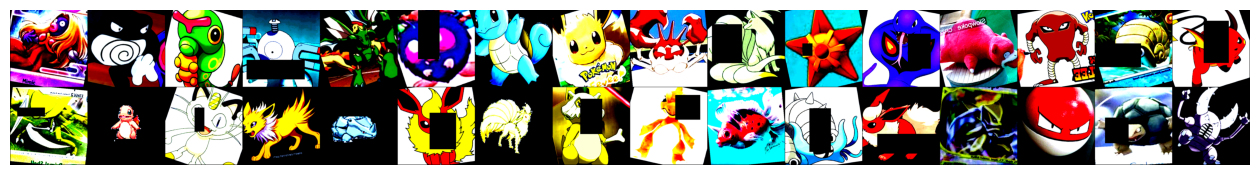

In [21]:
for images, _ in train_loader:
    print("images.shape:", images.shape)
    plt.figure(figsize=(16, 8))
    plt.axis("off")
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [22]:
for images, labels in train_loader:
    print("Batch of images shape:", images.shape)
    print("Batch of labels shape:", labels.shape)
    print("Labels:", labels)
    break

Batch of images shape: torch.Size([32, 3, 448, 448])
Batch of labels shape: torch.Size([32])
Labels: tensor([ 42,  43, 131, 131,  35,  75, 127, 109,  54,  22, 113,  65, 133,   8,  99, 128,  53,  37,  96,  75, 133, 144,  37,  45,   2,  60,  90, 134,  72, 140, 116, 109])


# Определение девайса

In [12]:
def define_device():
    """
    Definition of a device for performing calculations.
    """
    if torch.cuda.is_available():
        device_name = "cuda"
    elif torch.backends.mps.is_available():
        device_name = "mps"
    else:
        device_name = "cpu"
    return device_name

In [13]:
device = torch.device(define_device())
print(device)

mps


# Модели

## ResNet34

In [ ]:
def train_model(
    model,
    criterion,
    optimizer,
    scheduler,
    train_loader,
    device,
    n_epochs=5,
    batch_size=32,
):
    losses = []
    accuracies = []

    # Устанавливаем модель в режим обучения
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(train_loader, 0):

            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()  # Обнуляем градиенты

            # Прямой проход, обратный проход и оптимизация
            outputs = model(inputs)  # Прогоняем входные данные через модель
            _, predicted = torch.max(outputs.data, 1)  # Получаем предсказанные метки
            loss = criterion(outputs, labels)  # Считаем значение функции потерь
            loss.backward()  # Вычисляем градиенты
            optimizer.step()  # Обновляем параметры модели

            # Рассчитываем значение функции потерь и точности
            running_loss += loss.item()
            running_correct += (labels == predicted).sum().item()

        epoch_duration = time.time() - since  # Продолжительность эпохи
        epoch_loss = running_loss / len(
            train_loader
        )  # Среднее значение функции потерь за эпоху
        epoch_acc = (
            100 * running_correct / (len(train_loader) * batch_size)
        )  # Точность за эпоху
        print(
            "Epoch %s, duration: %d s, loss: %.4f, acc: %.4f"
            % (epoch + 1, epoch_duration, epoch_loss, epoch_acc)
        )

        losses.append(epoch_loss)  # Добавляем значение функции потерь в список
        accuracies.append(epoch_acc)  # Добавляем значение точности в список

    print("Finished Training")
    return (
        model,
        losses,
        accuracies,
    )  # Возвращаем обученную модель и списки значений потерь и точности

In [ ]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, num_of_unq_pokemons)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.85)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", patience=3, threshold=0.9
)

In [ ]:
model_ft, training_losses, training_accs = train_model(
    model_ft,
    criterion,
    optimizer,
    lrscheduler,
    n_epochs=4,
    batch_size=16,
    train_loader=train_loader,
    device=device,
)

In [ ]:
optimizer_lLR = optim.SGD(model_ft.parameters(), lr=0.002, momentum=0.95)

In [ ]:
model_ft, new_training_losses, new_training_accs = train_model(
    model_ft,
    criterion,
    optimizer_lLR,
    lrscheduler,
    n_epochs=2,
    batch_size=16,
    train_loader=train_loader,
    device=device,
)

In [ ]:
# Объедините старые и новые потери и точности для анализа
training_losses.extend(new_training_losses)
training_accs.extend(new_training_accs)

In [ ]:
plt.title("Training losses")
plt.plot(training_losses)

In [ ]:
plt.title("Training Accuracy")
plt.plot(training_accs)

### Формирование сабмита

In [ ]:
print(sorted(os.listdir("train_foldered")))

In [36]:
classes = [
    "Abra",
    "Aerodactyl",
    "Alakazam",
    "Alolan Sandslash",
    "Arbok",
    "Arcanine",
    "Articuno",
    "Beedrill",
    "Bellsprout",
    "Blastoise",
    "Bulbasaur",
    "Butterfree",
    "Caterpie",
    "Chansey",
    "Charizard",
    "Charmander",
    "Charmeleon",
    "Clefable",
    "Clefairy",
    "Cloyster",
    "Cubone",
    "Dewgong",
    "Diglett",
    "Ditto",
    "Dodrio",
    "Doduo",
    "Dragonair",
    "Dragonite",
    "Dratini",
    "Drowzee",
    "Dugtrio",
    "Eevee",
    "Ekans",
    "Electabuzz",
    "Electrode",
    "Exeggcute",
    "Exeggutor",
    "Farfetchd",
    "Fearow",
    "Flareon",
    "Gastly",
    "Gengar",
    "Geodude",
    "Gloom",
    "Golbat",
    "Goldeen",
    "Golduck",
    "Golem",
    "Graveler",
    "Grimer",
    "Growlithe",
    "Gyarados",
    "Haunter",
    "Hitmonchan",
    "Hitmonlee",
    "Horsea",
    "Hypno",
    "Ivysaur",
    "Jigglypuff",
    "Jolteon",
    "Jynx",
    "Kabuto",
    "Kabutops",
    "Kadabra",
    "Kakuna",
    "Kangaskhan",
    "Kingler",
    "Koffing",
    "Krabby",
    "Lapras",
    "Lickitung",
    "Machamp",
    "Machoke",
    "Machop",
    "Magikarp",
    "Magmar",
    "Magnemite",
    "Magneton",
    "Mankey",
    "Marowak",
    "Meowth",
    "Metapod",
    "Mew",
    "Mewtwo",
    "Moltres",
    "MrMime",
    "Muk",
    "Nidoking",
    "Nidoqueen",
    "Nidorina",
    "Nidorino",
    "Ninetales",
    "Oddish",
    "Omanyte",
    "Omastar",
    "Onix",
    "Paras",
    "Parasect",
    "Persian",
    "Pidgeot",
    "Pidgeotto",
    "Pidgey",
    "Pikachu",
    "Pinsir",
    "Poliwag",
    "Poliwhirl",
    "Poliwrath",
    "Ponyta",
    "Porygon",
    "Primeape",
    "Psyduck",
    "Raichu",
    "Rapidash",
    "Raticate",
    "Rattata",
    "Rhydon",
    "Rhyhorn",
    "Sandshrew",
    "Sandslash",
    "Scyther",
    "Seadra",
    "Seaking",
    "Secretok",
    "Seel",
    "Shellder",
    "Slowbro",
    "Slowpoke",
    "Snorlax",
    "Spearow",
    "Squirtle",
    "Starmie",
    "Staryu",
    "Tangela",
    "Tauros",
    "Tentacool",
    "Tentacruel",
    "Vaporeon",
    "Venomoth",
    "Venonat",
    "Venusaur",
    "Victreebel",
    "Vileplume",
    "Voltorb",
    "Vulpix",
    "Wartortle",
    "Weedle",
    "Weepinbell",
    "Weezing",
    "Wigglytuff",
    "Zapdos",
    "Zubat",
]

In [37]:
def predict_and_save_results(
    model, dataloader, device, classes, output_csv="predictions.csv"
):
    """
    Делает предсказания для тестовых данных и сохраняет результаты в файл CSV.

    Эта функция принимает обученную модель, загрузчик тестовых данных и список классов,
    делает предсказания для каждого изображения в тестовом наборе данных и сохраняет результаты
    в виде датафрейма с колонками "filename" (имя файла) и "label" (предсказанная категория).

    Параметры:
    model (torch.nn.Module): Обученная модель.
    dataloader (torch.utils.data.DataLoader): Загрузчик тестовых данных.
    device (torch.device): Устройство для выполнения вычислений (CPU или GPU).
    classes (list): Упорядоченный список классов.
    output_csv (str): Имя выходного CSV файла для сохранения результатов (по умолчанию 'predictions.csv').

    Возвращает:
    pandas.DataFrame: Датафрейм с предсказаниями, содержащий колонки "filename" и "label".
    """

    model.eval()  # Устанавливаем модель в режим оценки
    filenames = []
    predictions = []

    with torch.no_grad():
        start_index = 0  # Начальный индекс для каждого батча
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(len(preds)):
                # Используем корректный индекс для файла
                filenames.append(dataloader.dataset.samples[start_index + i][0])
                predictions.append(classes[preds[i].item()])

            start_index += len(
                inputs
            )  # Обновляем стартовый индекс для следующего батча

    results = pd.DataFrame(
        {"filename": [os.path.basename(f) for f in filenames], "label": predictions}
    )

    results.to_csv(output_csv, index=False)
    print(f"Результаты сохранены в {output_csv}")

    return results

### Предсказание

In [ ]:
results_df = predict_and_save_results(
    model_ft, test_loader, device, classes, output_csv="predictions.csv"
)

In [ ]:
# Проверка количества уникальных значений в столбце 'filename'
unique_filenames = results_df["filename"].nunique()
total_filenames = len(results_df["filename"])

print(f"Общее количество строк: {total_filenames}")
print(f"Количество уникальных значений в 'filename': {unique_filenames}")

## ResNet50

In [27]:
def setup_logging(save_dir, log_filename="training_log.log"):
    """
    Настройка логирования только в файл.

    Args:
        save_dir (str): Директория для сохранения файла логов.
        log_filename (str): Имя файла логов.
    """
    # Создаем директорию для логов, если она не существует
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Полный путь к файлу логов
    log_file = os.path.join(save_dir, log_filename)

    # Настройка логирования только в файл (без вывода в консоль)
    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s - %(levelname)s - %(message)s",
        handlers=[logging.FileHandler(log_file, mode="a")],  # Логирование только в файл
    )

    return log_file


def save_model(model, save_dir, epoch, note=""):
    """
    Сохраняет модель в указанной директории.

    Args:
        model (torch.nn.Module): Модель для сохранения.
        save_dir (str): Директория для сохранения модели.
        epoch (int): Номер текущей эпохи, для имени файла.
        note (str): Дополнительная заметка для имени файла.
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    save_path = os.path.join(save_dir, f"model_epoch_{epoch}{note}.pth")
    torch.save(model.state_dict(), save_path)
    logging.info(f"Model saved at epoch {epoch}: {save_path}")


def calculate_batch_size(train_loader):
    """
    Определяет размер батча на основе данных из train_loader.

    Args:
        train_loader (DataLoader): DataLoader с тренировочными данными.

    Returns:
        int: Размер батча (количество элементов в одном батче).
    """
    for data in train_loader:
        return data[0].size(0)  # Возвращаем размер первой размерности батча


def train_one_epoch(model, criterion, optimizer, train_loader, device, batch_size):
    """
    Обучает модель в течение одной эпохи.

    Args:
        model (torch.nn.Module): Модель, которую нужно обучить.
        criterion (torch.nn.Module): Функция потерь.
        optimizer (torch.optim.Optimizer): Оптимизатор для обновления параметров модели.
        train_loader (DataLoader): DataLoader с тренировочными данными.
        device (torch.device): Устройство, на котором будет выполняться обучение.
        batch_size (int): Размер батча.

    Returns:
        float: Среднее значение функции потерь за эпоху.
        float: Точность модели за эпоху (в процентах).
    """
    model.train()
    running_loss = 0.0
    running_correct = 0
    total_samples = 0

    # Используем tqdm для прогресса в течение эпохи
    progress_bar = tqdm(train_loader, desc="Training", leave=False)

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)  # Умножаем на количество элементов
        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        # Обновляем прогресс-бар с текущей потерей
        progress_bar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / total_samples
    epoch_acc = 100.0 * running_correct / total_samples

    return epoch_loss, epoch_acc


def train_model(
    model,
    criterion,
    optimizer,
    scheduler,
    train_loader,
    device,
    save_dir,
    n_epochs=5,
    save_every=5,
    acc_threshold=90.0,  # Порог точности для сохранения модели.
):
    """
    Обучает модель на протяжении нескольких эпох и сохраняет модель при достижении определенной точности.

    Args:
        model (torch.nn.Module): Модель, которую нужно обучить.
        criterion (torch.nn.Module): Функция потерь.
        optimizer (torch.optim.Optimizer): Оптимизатор для обновления параметров модели.
        scheduler (torch.optim.lr_scheduler): Планировщик изменения скорости обучения (если используется).
        train_loader (DataLoader): DataLoader с тренировочными данными.
        device (torch.device): Устройство, на котором будет выполняться обучение.
        save_dir (str): Директория для сохранения моделей и логов.
        n_epochs (int, optional): Количество эпох обучения. По умолчанию 5.
        save_every (int, optional): Сохранять модель каждые n эпох. По умолчанию 5.
        acc_threshold (float, optional): Порог точности для сохранения модели. По умолчанию 90.0.

    Returns:
        torch.nn.Module: Обученная модель.
        list of float: Список средних значений функции потерь за каждую эпоху.
        list of float: Список точностей за каждую эпоху.
    """
    # Настраиваем логирование и получаем путь к файлу логов
    log_file = setup_logging(save_dir)

    losses = []
    accuracies = []
    batch_size = calculate_batch_size(train_loader)  # Определяем размер батча

    for epoch in range(n_epochs):
        since = time.time()

        # Вывод информации об эпохе и точности через print
        print(f"Epoch {epoch + 1}/{n_epochs} started")

        # Обучение за одну эпоху
        epoch_loss, epoch_acc = train_one_epoch(
            model, criterion, optimizer, train_loader, device, batch_size
        )

        scheduler.step(
            epoch_acc
        )  # Обновляем scheduler после каждой эпохи (если используется)
        epoch_duration = time.time() - since

        # Получаем текущий learning rate
        current_lr = optimizer.param_groups[0]["lr"]

        # Логирование в файл всей информации
        logging.info(
            f"Epoch {epoch + 1}/{n_epochs}, duration: {int(epoch_duration)} s, "
            f"loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f}, lr: {current_lr:.6f}"
        )

        # Вывод в консоль только эпоху и точность
        print(f"Epoch {epoch + 1}/{n_epochs}, acc: {epoch_acc:.4f}")

        losses.append(epoch_loss)
        accuracies.append(epoch_acc)

        # Сохраняем модель каждые n эпох, если она прошла порог точности
        if (epoch + 1) % save_every == 0 and epoch_acc >= acc_threshold:
            save_model(model, save_dir, epoch + 1)

    print("Finished Training")
    return model, losses, accuracies

### Модель V1

In [32]:
weights = ResNet50_Weights.IMAGENET1K_V2
# Определение модели ResNet50
model_ft = models.resnet50(weights=weights)
num_ftrs = model_ft.fc.in_features

# Замена последнего слоя на классификацию с нужным количеством классов
model_ft.fc = nn.Linear(num_ftrs, num_of_unq_pokemons)
model_ft = model_ft.to(device)

# Определение функции потерь, оптимизатора и планировщика обучения
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.85)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", patience=2, threshold=0.1, factor=0.2
)

# Путь для сохранения модели
save_dir = "./resnet50_epoch_models"
save_every = 1

#### Обучение

In [33]:
model_ft, training_losses, training_accs = train_model(
    model_ft,
    criterion,
    optimizer,
    lrscheduler,
    n_epochs=50,
    train_loader=train_loader,
    device=device,
    save_dir=save_dir,
    save_every=save_every,
)

Epoch 1/50 started


Epoch 1/50, acc: 6.0532
Epoch 2/50 started


Epoch 2/50, acc: 48.2429
Epoch 3/50 started


Epoch 3/50, acc: 82.3482
Epoch 4/50 started


Epoch 4/50, acc: 91.1030
Epoch 5/50 started


Epoch 5/50, acc: 94.4343
Epoch 6/50 started


Epoch 6/50, acc: 96.3843
Epoch 7/50 started


Epoch 7/50, acc: 97.4406
Epoch 8/50 started


Epoch 8/50, acc: 98.4359
Epoch 9/50 started


Epoch 9/50, acc: 98.7812
Epoch 10/50 started


Epoch 10/50, acc: 98.8625
Epoch 11/50 started


Epoch 11/50, acc: 98.9234
Epoch 12/50 started


Epoch 12/50, acc: 99.0656
Epoch 13/50 started


Epoch 13/50, acc: 98.9844
Epoch 14/50 started


Epoch 14/50, acc: 99.2484
Epoch 15/50 started


Epoch 15/50, acc: 98.7406
Epoch 16/50 started


Epoch 16/50, acc: 99.0250
Epoch 17/50 started


Epoch 17/50, acc: 99.0453
Epoch 18/50 started


Epoch 18/50, acc: 98.7609
Epoch 19/50 started


Epoch 19/50, acc: 98.9031
Epoch 20/50 started


Epoch 20/50, acc: 98.8219
Epoch 21/50 started


Epoch 21/50, acc: 98.7203
Epoch 22/50 started


Epoch 22/50, acc: 99.0656
Epoch 23/50 started


Epoch 23/50, acc: 98.9640
Epoch 24/50 started


Epoch 24/50, acc: 99.1062
Epoch 25/50 started


Epoch 25/50, acc: 99.0656
Epoch 26/50 started


Epoch 26/50, acc: 98.5984
Epoch 27/50 started


Epoch 27/50, acc: 99.2078
Epoch 28/50 started


Epoch 28/50, acc: 98.8422
Epoch 29/50 started


Epoch 29/50, acc: 99.1265
Epoch 30/50 started


Epoch 30/50, acc: 99.0047
Epoch 31/50 started


Epoch 31/50, acc: 98.8625
Epoch 32/50 started


Training:  42%|████▏     | 64/154 [01:15<01:27,  1.03it/s, loss=0.0356]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x309dc3e20>
Traceback (most recent call last):
  File "/Users/roman/miniconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/Users/roman/miniconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/roman/miniconda3/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/roman/miniconda3/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/roman/miniconda3/lib/python3.11/multiprocessing/connection.py", line 930, in wait
    ready = selector.select(timeout)
   

### Модель V2

In [34]:
weights = ResNet50_Weights.IMAGENET1K_V2
# Определение модели ResNet50
model_ft = models.resnet50(weights=weights)
num_ftrs = model_ft.fc.in_features

# Замена последнего слоя на классификацию с нужным количеством классов
model_ft.fc = nn.Linear(num_ftrs, num_of_unq_pokemons)
model_ft = model_ft.to(device)

# Определение функции потерь, оптимизатора и планировщика обучения
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.85)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", patience=1, threshold=0.1, factor=0.3
)

# Путь для сохранения модели
save_dir = "./resnet50_epoch_models_2"
save_every = 1

#### Обучение

In [35]:
model_ft, training_losses, training_accs = train_model(
    model_ft,
    criterion,
    optimizer,
    lrscheduler,
    n_epochs=50,
    train_loader=train_loader,
    device=device,
    save_dir=save_dir,
    save_every=save_every,
)

Epoch 1/50 started


Epoch 1/50, acc: 7.4345
Epoch 2/50 started


Epoch 2/50, acc: 52.4071
Epoch 3/50 started


Epoch 3/50, acc: 83.5060
Epoch 4/50 started


Epoch 4/50, acc: 91.2046
Epoch 5/50 started


Epoch 5/50, acc: 94.4749
Epoch 6/50 started


Epoch 6/50, acc: 96.6078
Epoch 7/50 started


Epoch 7/50, acc: 97.3187
Epoch 8/50 started


Epoch 8/50, acc: 98.4562
Epoch 9/50 started


Epoch 9/50, acc: 98.6797
Epoch 10/50 started


Epoch 10/50, acc: 98.8422
Epoch 11/50 started


Epoch 11/50, acc: 98.9844
Epoch 12/50 started


Epoch 12/50, acc: 98.9234
Epoch 13/50 started


Training:   0%|          | 0/154 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x309dc3e20>
Traceback (most recent call last):
  File "/Users/roman/miniconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/Users/roman/miniconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/roman/miniconda3/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/roman/miniconda3/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/roman/miniconda3/lib/python3.11/multiprocessing/connection.py", line 930, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^

### Предсказание для моделей на разных эпохах

In [49]:
weights = ResNet50_Weights.IMAGENET1K_V2
# Определение модели ResNet50
model_ft = models.resnet50(weights=weights)
num_ftrs = model_ft.fc.in_features
# Замена последнего слоя на классификацию с нужным количеством классов
model_ft.fc = nn.Linear(num_ftrs, num_of_unq_pokemons)
model_ft = model_ft.to(device)

In [50]:
model_ft.load_state_dict(
    torch.load(
        "resnet50_epoch_models/model_epoch_12.pth", map_location=torch.device("mps")
    )
)
predict_and_save_results(
    model_ft,
    test_loader,
    device,
    classes,
    output_csv="Submission/predictions_resnet50_12ep.csv",
)

Результаты сохранены в Submission/predictions_resnet50_12ep.csv


,filename,label
0,002562cdd2d17ee1e67fb26a309ed1edef4b8219eb2233...,Cloyster
1,002b01cfd29fd12cbd48b042cca54b7b031b3a3d0adeb9...,Poliwag
2,002d30ddeff893fdca5e187e4f348f6f537b2f80d8d2a3...,Squirtle
3,0073c8c962ea13ae6e838a5f2d38f7f12b096abb2f2a90...,Clefable
4,00adf017914bb974c2524a3fd2fc049b08f83cb07480a6...,Staryu
...,...,...
2041,fec6f8f6ea7955eea8ca1b53204ebc0e62de29d93bce05...,Vulpix
2042,fef4c94968e13ad30e081e94a3b24fa815a22fb79a43c3...,Alolan Sandslash
2043,ff1830fd4fbb147d9b385e9be0a5eeb2745478cf8d2338...,Machop
2044,ff516479938d0fc78b67e2c90a70703b0239e40a81b959...,Drowzee


In [51]:
model_ft.load_state_dict(
    torch.load(
        "resnet50_epoch_models/model_epoch_10.pth", map_location=torch.device("mps")
    )
)
predict_and_save_results(
    model_ft,
    test_loader,
    device,
    classes,
    output_csv="Submission/predictions_resnet50_10ep.csv",
)

Результаты сохранены в Submission/predictions_resnet50_10ep.csv


,filename,label
0,002562cdd2d17ee1e67fb26a309ed1edef4b8219eb2233...,Cloyster
1,002b01cfd29fd12cbd48b042cca54b7b031b3a3d0adeb9...,Poliwag
2,002d30ddeff893fdca5e187e4f348f6f537b2f80d8d2a3...,Squirtle
3,0073c8c962ea13ae6e838a5f2d38f7f12b096abb2f2a90...,Clefable
4,00adf017914bb974c2524a3fd2fc049b08f83cb07480a6...,Staryu
...,...,...
2041,fec6f8f6ea7955eea8ca1b53204ebc0e62de29d93bce05...,Vulpix
2042,fef4c94968e13ad30e081e94a3b24fa815a22fb79a43c3...,Alolan Sandslash
2043,ff1830fd4fbb147d9b385e9be0a5eeb2745478cf8d2338...,Machop
2044,ff516479938d0fc78b67e2c90a70703b0239e40a81b959...,Drowzee


In [52]:
model_ft.load_state_dict(
    torch.load(
        "resnet50_epoch_models_2/model_epoch_11.pth", map_location=torch.device("mps")
    )
)
predict_and_save_results(
    model_ft,
    test_loader,
    device,
    classes,
    output_csv="Submission/predictions_resnet50_v2_11ep.csv",
)

Результаты сохранены в Submission/predictions_resnet50_v2_11ep.csv


,filename,label
0,002562cdd2d17ee1e67fb26a309ed1edef4b8219eb2233...,Cloyster
1,002b01cfd29fd12cbd48b042cca54b7b031b3a3d0adeb9...,Poliwag
2,002d30ddeff893fdca5e187e4f348f6f537b2f80d8d2a3...,Squirtle
3,0073c8c962ea13ae6e838a5f2d38f7f12b096abb2f2a90...,Clefable
4,00adf017914bb974c2524a3fd2fc049b08f83cb07480a6...,Staryu
...,...,...
2041,fec6f8f6ea7955eea8ca1b53204ebc0e62de29d93bce05...,Vulpix
2042,fef4c94968e13ad30e081e94a3b24fa815a22fb79a43c3...,Alolan Sandslash
2043,ff1830fd4fbb147d9b385e9be0a5eeb2745478cf8d2338...,Machop
2044,ff516479938d0fc78b67e2c90a70703b0239e40a81b959...,Drowzee


## EfficientNetV2 small

In [74]:
# Загружаем предобученные веса EfficientNet V2 Small
weights = EfficientNet_V2_S_Weights.DEFAULT
model_ft = models.efficientnet_v2_s(weights=weights)

# Получаем количество входных признаков для последнего слоя
num_ftrs = model_ft.classifier[1].in_features

# Замена последнего слоя на классификацию с нужным количеством классов
model_ft.classifier[1] = nn.Linear(num_ftrs, num_of_unq_pokemons)
model_ft = model_ft.to(device)

# Определение функции потерь, оптимизатора и планировщика обучения
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.85)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", patience=2, threshold=0.1
)

# Путь для сохранения модели
save_dir = "./EfficientNet_V2_epoch_models_SGD"
save_every = 1

### Обучение (На Kaggle)

In [ ]:
model_ft, training_losses, training_accs = train_model(
    model_ft,
    criterion,
    optimizer,
    lrscheduler,
    n_epochs=200,
    train_loader=train_loader,
    device=device,
    save_dir=save_dir,
    save_every=save_every,
)

### Предсказание для моделей на разных эпохах

In [39]:
folder_path = Path("Efficient_Net_SGD_2")
objects = list(folder_path.iterdir())
print(objects)

[PosixPath('Efficient_Net_SGD_2/model_epoch_8.pth'), PosixPath('Efficient_Net_SGD_2/model_epoch_12.pth')]


In [40]:
folder_path = Path("Efficient_Net_SGD")
objects = list(folder_path.iterdir())
print(objects)

[PosixPath('Efficient_Net_SGD/model_epoch_16.pth'), PosixPath('Efficient_Net_SGD/model_epoch_38.pth'), PosixPath('Efficient_Net_SGD/model_epoch_11.pth')]


In [ ]:
# Инициализация модели с предобученными весами
weights = EfficientNet_V2_S_Weights.DEFAULT
model_ft = models.efficientnet_v2_s(weights=weights)
# Изменение последнего слоя для классификации нужного количества классов
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, num_of_unq_pokemons)
# Перенос модели на устройство
model_ft = model_ft.to(device)

In [ ]:
# Загрузка обученных весов
model_ft.load_state_dict(
    torch.load(
        "Efficient_Net_SGD_2/model_epoch_8.pth", map_location=torch.device("mps")
    )
)
predict_and_save_results(
    model_ft,
    test_loader,
    device,
    classes,
    output_csv="Submission/predictions_Efficient_Net_SGD_8ep.csv",
)

Результаты сохранены в Submission/predictions_Efficient_Net_SGD_8ep.csv


,filename,label
0,002562cdd2d17ee1e67fb26a309ed1edef4b8219eb2233...,Cloyster
1,002b01cfd29fd12cbd48b042cca54b7b031b3a3d0adeb9...,Omanyte
2,002d30ddeff893fdca5e187e4f348f6f537b2f80d8d2a3...,Squirtle
3,0073c8c962ea13ae6e838a5f2d38f7f12b096abb2f2a90...,Clefable
4,00adf017914bb974c2524a3fd2fc049b08f83cb07480a6...,Staryu
...,...,...
2041,fec6f8f6ea7955eea8ca1b53204ebc0e62de29d93bce05...,Vulpix
2042,fef4c94968e13ad30e081e94a3b24fa815a22fb79a43c3...,Alolan Sandslash
2043,ff1830fd4fbb147d9b385e9be0a5eeb2745478cf8d2338...,Machop
2044,ff516479938d0fc78b67e2c90a70703b0239e40a81b959...,Drowzee


In [45]:
model_ft.load_state_dict(
    torch.load(
        "Efficient_Net_SGD_2/model_epoch_12.pth", map_location=torch.device("mps")
    )
)
predict_and_save_results(
    model_ft,
    test_loader,
    device,
    classes,
    output_csv="Submission/predictions_Efficient_Net_SGD_12ep.csv",
)

Результаты сохранены в Submission/predictions_Efficient_Net_SGD_12ep.csv


,filename,label
0,002562cdd2d17ee1e67fb26a309ed1edef4b8219eb2233...,Cloyster
1,002b01cfd29fd12cbd48b042cca54b7b031b3a3d0adeb9...,Omanyte
2,002d30ddeff893fdca5e187e4f348f6f537b2f80d8d2a3...,Squirtle
3,0073c8c962ea13ae6e838a5f2d38f7f12b096abb2f2a90...,Clefable
4,00adf017914bb974c2524a3fd2fc049b08f83cb07480a6...,Staryu
...,...,...
2041,fec6f8f6ea7955eea8ca1b53204ebc0e62de29d93bce05...,Vulpix
2042,fef4c94968e13ad30e081e94a3b24fa815a22fb79a43c3...,Alolan Sandslash
2043,ff1830fd4fbb147d9b385e9be0a5eeb2745478cf8d2338...,Machop
2044,ff516479938d0fc78b67e2c90a70703b0239e40a81b959...,Drowzee


In [46]:
model_ft.load_state_dict(
    torch.load("Efficient_Net_SGD/model_epoch_16.pth", map_location=torch.device("mps"))
)
predict_and_save_results(
    model_ft,
    test_loader,
    device,
    classes,
    output_csv="Submission/predictions_Efficient_Net_SGD_16ep.csv",
)

Результаты сохранены в Submission/predictions_Efficient_Net_SGD_v2_16ep.csv


,filename,label
0,002562cdd2d17ee1e67fb26a309ed1edef4b8219eb2233...,Cloyster
1,002b01cfd29fd12cbd48b042cca54b7b031b3a3d0adeb9...,Omanyte
2,002d30ddeff893fdca5e187e4f348f6f537b2f80d8d2a3...,Squirtle
3,0073c8c962ea13ae6e838a5f2d38f7f12b096abb2f2a90...,Clefable
4,00adf017914bb974c2524a3fd2fc049b08f83cb07480a6...,Staryu
...,...,...
2041,fec6f8f6ea7955eea8ca1b53204ebc0e62de29d93bce05...,Vulpix
2042,fef4c94968e13ad30e081e94a3b24fa815a22fb79a43c3...,Alolan Sandslash
2043,ff1830fd4fbb147d9b385e9be0a5eeb2745478cf8d2338...,Machop
2044,ff516479938d0fc78b67e2c90a70703b0239e40a81b959...,Drowzee


In [47]:
model_ft.load_state_dict(
    torch.load("Efficient_Net_SGD/model_epoch_38.pth", map_location=torch.device("mps"))
)
predict_and_save_results(
    model_ft,
    test_loader,
    device,
    classes,
    output_csv="Submission/predictions_Efficient_Net_SGD_v2_38ep.csv",
)

Результаты сохранены в Submission/predictions_Efficient_Net_SGD_v2_38ep.csv


,filename,label
0,002562cdd2d17ee1e67fb26a309ed1edef4b8219eb2233...,Cloyster
1,002b01cfd29fd12cbd48b042cca54b7b031b3a3d0adeb9...,Omanyte
2,002d30ddeff893fdca5e187e4f348f6f537b2f80d8d2a3...,Squirtle
3,0073c8c962ea13ae6e838a5f2d38f7f12b096abb2f2a90...,Clefable
4,00adf017914bb974c2524a3fd2fc049b08f83cb07480a6...,Staryu
...,...,...
2041,fec6f8f6ea7955eea8ca1b53204ebc0e62de29d93bce05...,Vulpix
2042,fef4c94968e13ad30e081e94a3b24fa815a22fb79a43c3...,Alolan Sandslash
2043,ff1830fd4fbb147d9b385e9be0a5eeb2745478cf8d2338...,Machop
2044,ff516479938d0fc78b67e2c90a70703b0239e40a81b959...,Drowzee


In [48]:
model_ft.load_state_dict(
    torch.load("Efficient_Net_SGD/model_epoch_11.pth", map_location=torch.device("mps"))
)
predict_and_save_results(
    model_ft,
    test_loader,
    device,
    classes,
    output_csv="Submission/predictions_Efficient_Net_SGD_v2_11ep.csv",
)

Результаты сохранены в Submission/predictions_Efficient_Net_SGD_v2_11ep.csv


,filename,label
0,002562cdd2d17ee1e67fb26a309ed1edef4b8219eb2233...,Cloyster
1,002b01cfd29fd12cbd48b042cca54b7b031b3a3d0adeb9...,Omanyte
2,002d30ddeff893fdca5e187e4f348f6f537b2f80d8d2a3...,Squirtle
3,0073c8c962ea13ae6e838a5f2d38f7f12b096abb2f2a90...,Clefable
4,00adf017914bb974c2524a3fd2fc049b08f83cb07480a6...,Staryu
...,...,...
2041,fec6f8f6ea7955eea8ca1b53204ebc0e62de29d93bce05...,Vulpix
2042,fef4c94968e13ad30e081e94a3b24fa815a22fb79a43c3...,Alolan Sandslash
2043,ff1830fd4fbb147d9b385e9be0a5eeb2745478cf8d2338...,Machop
2044,ff516479938d0fc78b67e2c90a70703b0239e40a81b959...,Drowzee


## Baseline подход

In [36]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    model.train()
    model.zero_grad()

    output = model(x_batch.to(model.device))
    loss = loss_function(output, y_batch.to(model.device))
    loss.backward()

    optimizer.step()
    return loss.cpu().item()


# Функция для обучения модели в течение одной эпохи
def train_epoch(train_loader, model, loss_function, optimizer, callback=None):
    epoch_loss = 0
    total = 0

    for it, (batch_of_x, batch_of_y) in enumerate(train_loader):
        batch_loss = train_on_batch(
            model, batch_of_x, batch_of_y, optimizer, loss_function
        )

        if callback is not None:
            callback(model, batch_loss)

        epoch_loss += batch_loss * len(batch_of_x)
        total += len(batch_of_x)

    return epoch_loss / total


# Основная функция тренировки модели
def trainer(
    count_of_epoch,
    train_loader,
    model,
    loss_function,
    optimizer,
    callback=None,
):

    iterations = tqdm(range(count_of_epoch), desc="epoch")
    iterations.set_postfix({"train epoch loss": np.nan})

    for it in iterations:
        epoch_loss = train_epoch(
            train_loader=train_loader,
            model=model,
            loss_function=loss_function,
            optimizer=optimizer,
            callback=callback,
        )

        iterations.set_postfix({"train epoch loss": epoch_loss})


class CustomCNN(nn.Module):
    @property
    def device(self):
        for p in self.parameters():
            return p.device

    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = None
        self.bn4 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)

        if self.fc1 is None:
            self.fc1 = nn.Linear(x.size(1), 512).to(self.device)

        x = F.relu(self.bn4(self.fc1(x)))
        x = self.fc2(x)

        return x

### Определение модели

In [37]:
model = CustomCNN(num_classes=num_of_unq_pokemons)
model = model.to(device)

### Определение функции потерь и оптимизатора

In [38]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.85)

### Обучение

In [39]:
trainer(
    count_of_epoch=10,
    train_loader=train_loader,
    model=model,
    loss_function=loss_function,
    optimizer=optimizer,
)

epoch: 100%|██████████| 10/10 [10:54<00:00, 65.43s/it, train epoch loss=2.76]


In [40]:
trainer(
    count_of_epoch=15,
    train_loader=train_loader,
    model=model,
    loss_function=loss_function,
    optimizer=optimizer,
)

epoch: 100%|██████████| 15/15 [16:59<00:00, 67.94s/it, train epoch loss=2.18]


In [ ]:
torch.save(model.state_dict(), "model.pth")

### Предсказание

In [ ]:
predict_and_save_results(
    model, test_loader, device, classes, output_csv="predictions_baseline.csv"
)

## YoloV8

In [60]:
def count_files_in_directory(directory):
    """
    Подсчитывает количество файлов в директории, исключая скрытые файлы и папки.
    """
    return sum(
        1
        for item in os.listdir(directory)
        if os.path.isfile(os.path.join(directory, item)) and not item.startswith(".")
    )


def split_dataset(base_dir, val_split, remove_from_train=True):
    """
    Разделяет датасет на тренировочную и валидационную выборки и опционально копирует файлы в валидацию.

    Функция перемещает все изображения из папок с лейблами в соответствующие папки для тренировочной
    выборки, затем опционально копирует или перемещает их в валидационную выборку. После перемещения файлы в
    исходных папках удаляются. Также выводит количество изображений в папках 'train' и 'val' для каждого класса.

    :param base_dir: Путь к основной папке с данными, содержащей папки с лейблами.
    :param val_split: Процент изображений, которые должны быть скопированы или перемещены в валидационную выборку (например, 0.2 для 20%).
    :param remove_from_train: Если True, изображения перемещаются из train в val. Если False, изображения только копируются в val.
    """

    # Создание путей к папкам train и val
    train_dir = os.path.join(base_dir, "train")
    val_dir = os.path.join(base_dir, "val")

    # Создание папок train и val, если они не существуют
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Словарь для хранения количества изображений в train и val
    class_counts = {}

    # Перебор всех папок с лейблами в исходной директории
    for label in os.listdir(base_dir):
        label_path = os.path.join(base_dir, label)

        # Пропускаем папки train и val, если они уже существуют
        if os.path.isdir(label_path) and label not in ["train", "val"]:
            # Путь к папкам с лейблом в train и val
            train_label_dir = os.path.join(train_dir, label)
            val_label_dir = os.path.join(val_dir, label)

            # Создание папок для каждого лейбла в train и val
            os.makedirs(train_label_dir, exist_ok=True)
            os.makedirs(val_label_dir, exist_ok=True)

            # Получение всех изображений в папке с лейблом
            images = [
                img
                for img in os.listdir(label_path)
                if os.path.isfile(os.path.join(label_path, img))
                and not img.startswith(".")
            ]

            # Перемешивание изображений для случайного выбора
            random.shuffle(images)

            # Перемещение всех изображений в train
            for img in images:
                src_path = os.path.join(label_path, img)
                dest_path = os.path.join(train_label_dir, img)
                shutil.move(src_path, dest_path)

            # Опциональное перемещение или копирование изображений в val
            val_count = ceil(len(images) * val_split)
            if remove_from_train:
                # Перемещение файлов из train в val
                for img in images[:val_count]:
                    src_path = os.path.join(train_label_dir, img)
                    dest_path = os.path.join(val_label_dir, img)
                    shutil.move(src_path, dest_path)
            else:
                # Копирование файлов из train в val
                for img in images[:val_count]:
                    src_path = os.path.join(train_label_dir, img)
                    dest_path = os.path.join(val_label_dir, img)
                    shutil.copy(src_path, dest_path)

            # Обновление счётчика для текущего класса
            train_count = count_files_in_directory(train_label_dir)
            val_count = count_files_in_directory(val_label_dir)
            class_counts[label] = {"train": train_count, "val": val_count}

            # Удаление исходной папки с лейблом
            shutil.rmtree(label_path)

    # Вывод количества изображений в train и val для каждого класса
    print(f"{'Class':<15} {'Train':<10} {'Val':<10}")
    print("-" * 35)
    for label, counts in class_counts.items():
        print(f"{label:<15} {counts['train']:<10} {counts['val']:<10}")

    print("\nДатасет успешно разделен на тренировочную и валидационную выборки.")

In [61]:
print(sorted(os.listdir("yolo_full_train")))

['.DS_Store', 'Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'MrMime', 'Muk', 'N

In [62]:
print(len(sorted(os.listdir("yolo_full_train"))))

152


In [63]:
split_dataset("yolo_full_train", val_split=0.1, remove_from_train=False)

Class           Train      Val       
-----------------------------------
Zapdos          37         4         
Kadabra         35         4         
Alolan Sandslash 29         3         
Omanyte         32         4         
Shellder        33         4         
Bellsprout      29         3         
Eevee           27         3         
Jolteon         37         4         
Hypno           34         4         
Seel            35         4         
Zubat           29         3         
Graveler        28         3         
Magneton        30         3         
Abra            26         3         
Kingler         34         4         
Alakazam        19         2         
Clefable        28         3         
Gyarados        33         4         
Poliwag         36         4         
Rapidash        35         4         
Machamp         38         4         
Pinsir          30         3         
Muk             31         4         
Seaking         33         4         
Magikarp     

In [64]:
# Load a model
model = YOLO("yolov8x-cls.pt")  # load a pretrained model (recommended for training)

In [65]:
# Display model information (optional)
model.info()

YOLOv8x-cls summary: 183 layers, 57,422,840 parameters, 0 gradients, 155.3 GFLOPs


(183, 57422840, 0, 155.334656)

### Обучение (на Kaggle)

In [67]:
# !yolo settings tensorboard=False

In [ ]:
# !yolo settings wandb=False

In [ ]:
# !pip uninstall wandb -y

In [ ]:
# import os
# os.environ["WANDB_MODE"] = "dryrun"

In [11]:
# Настройки гиперпараметров для обучения
epochs = 8  # Количество эпох обучения
batch_size = 32  # Размер батча
img_size = 448  # Размер изображений для подачи в модель

In [ ]:
# Настройка обучения модели
model.train(
    data="/kaggle/input/pokemon/yolo_full_train",  # Путь к данным
    epochs=epochs,  # Количество эпох обучения
    batch=batch_size,  # Размер батча
    imgsz=img_size,  # Размер входных изображений
    workers=6,  # Количество потоков для загрузки данных
    optimizer="auto",  # Оптимизатор для обучения
    val=True,  # Включение валидации на каждой эпохе
    project="YOLOv8_training_train",  # Путь к директории для сохранения результатов
    name="yolov8x_finetune",  # Название эксперимента
    verbose=True,  # Логирование обучения в консоль
    save_period=1,  # Сохранение модели каждые N эпох
    cache=True,  # Кэширование данных для ускорения обучения
    device=0,
    augment=True,  # Включение аугментации
    scale=0.6,  # Масштабирование
    translate=0.2,  # Сдвиг изображения
    degrees=15,  # Поворот изображения
    fliplr=0.5,  # Включение горизонтального отражения
    mosaic=0,
    erasing=0.3,
)

In [23]:
def predict_images_in_batches(model, image_folder, batch_size=32, img_size=64):
    """
    Делает предсказания для всех изображений в указанной папке батчами и формирует DataFrame с результатами.

    :param model: Загруженная модель YOLO для предсказаний.
    :param image_folder: Путь к папке, содержащей изображения.
    :param batch_size: Размер батча.
    :param img_size: Размер изображения для предсказания.
    :return: DataFrame с двумя столбцами: 'filename' и 'label'.
             'filename' содержит имя файла изображения, 'label' - предсказанный класс.
    """

    # Список для хранения путей к изображениям и предсказаний
    image_paths = []
    filenames = []
    labels = []

    # Перебор всех файлов в папке
    for filename in tqdm(os.listdir(image_folder), desc="Обработка изображений"):
        image_path = os.path.join(image_folder, filename)
        if os.path.isfile(image_path):
            image_paths.append(image_path)
            filenames.append(filename)

    # Итеративная обработка изображений батчами
    for i in tqdm(range(0, len(image_paths), batch_size), desc="Предсказание батчами"):
        batch_paths = image_paths[i : i + batch_size]
        results = model(
            batch_paths, stream=True, imgsz=img_size, device=0, verbose=False
        )

        for result in results:
            predicted_class = result.names[result.probs.top1]
            labels.append(predicted_class)

    # Преобразование в DataFrame
    df = pd.DataFrame({"filename": filenames, "label": labels})

    return df

### Предсказание

In [24]:
model = YOLO("YOLOv8_training/yolov8x_finetune/weights/epoch5.pt")

In [25]:
result_df = predict_images_in_batches(
    model, "test_foldered/no_label", batch_size=32, img_size=img_size
)

Предсказание батчами: 100%|██████████| 64/64 [00:39<00:00,  1.62it/s]


In [26]:
result_df.head()

,filename,label
0,560457a55164cf8278a3b88fedff2e8acb460e03fd6ce4...,Vileplume
1,58b1a694eba721b523ef0fbfa46c7d7e0c11cf639e8fc2...,Exeggutor
2,9f788d6908f19d426e59828402f338cd483d2ae49ecbf7...,Moltres
3,dde329aadc73a1aadf722bf5b64397d2f94b080269de97...,Cubone
4,74094cb0108395545148d96fca368e4d14ec3f3f128608...,Blastoise


In [27]:
result_df.to_csv("yolo_finetune_prediction.csv", index=False)

# Conclusion

## Models studied
* ResNet34
* ResNet50
* EfficientNetV2 small
* YoloV8 Classification

The best result was shown by EfficientNetV2 small: public score = 0.976539

## Improvements
* It is worth considering EfficientNetV2 medium on data with more augmentation.
* It is worth improving the classification head after the pre-trained model layer.
* It would be possible to further expand the dataset with images from other datasets, but I did not want the test sample with labels to end up in the train

# Вывод

## Исследованные модели
* ResNet34
* ResNet50
* EfficientNetV2 small
* YoloV8 Classification

Лучший результат показала EfficientNetV2 small: public score = 0.976539

## Улучшения
* Стоит рассмотреть EfficientNetV2 medium на данных с большей аугментацией.
* Стоит улучшить голову классификации после слоя предобученной модели.
* Можно было бы еще расширить датасет изображениями из других датасетов, но не хотелось попадания тестовой выборки с метками в train